In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
def load_images_from_dir(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(directory, filename))
            # Resizing 
            img = cv2.resize(img, (224, 224))
            img = img.astype(np.float32) / 255.0
            images.append(img)
            labels.append(directory.split('/')[-1])  
    return np.array(images), np.array(labels)

In [9]:
#variable assignment
ad_creatives_dir = "ad-creatives"
non_ad_creatives_dir = "non_ad-creatives"
ad_images, ad_labels = load_images_from_dir(ad_creatives_dir)
non_ad_images, non_ad_labels = load_images_from_dir(non_ad_creatives_dir)
all_images = np.concatenate((ad_images, non_ad_images), axis=0)
all_labels = np.concatenate((ad_labels, non_ad_labels), axis=0)
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]
print("Shape of all images:", all_images.shape)
print("Shape of all labels:", all_labels.shape)

Shape of all images: (900, 224, 224, 3)
Shape of all labels: (900,)


In [10]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest'     
)
def augment_images(images):
    augmented_images = []
    for image in images:
        image = np.expand_dims(image, axis=0)  
        augmented_image = next(datagen.flow(image))[0]
        augmented_images.append(augmented_image)
    return np.array(augmented_images)

In [ ]:
augmented_ad_images = augment_images(ad_images)
augmented_non_ad_images = augment_images(non_ad_images)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#categorical to numerical
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (576, 224, 224, 3)
Shape of y_train: (576,)
Shape of X_val: (144, 224, 224, 3)
Shape of y_val: (144,)
Shape of X_test: (180, 224, 224, 3)
Shape of y_test: (180,)


In [17]:
#ResNet would be a good choice here for model building.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)
optimizer = Adam(learning_rate=learning_rate_schedule)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
#Now training the model
history = model.fit(
    X_train, y_train,
    epochs=10,  
    batch_size=32,  
    validation_data=(X_val, y_val),
    verbose=1
)
print("hello")
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5043 - loss: 0.7932 - val_accuracy: 0.5417 - val_loss: 0.6677
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5323 - loss: 0.6707 - val_accuracy: 0.5972 - val_loss: 0.6541
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.6260 - loss: 0.6143 - val_accuracy: 0.6667 - val_loss: 0.6522
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6620 - loss: 0.6199 - val_accuracy: 0.6111 - val_loss: 0.6476
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6189 - loss: 0.6098 - val_accuracy: 0.6667 - val_loss: 0.6287
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.6637 - loss: 0.6025 - val_accuracy: 0.7083 - val_loss: 0.6351
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6587 - loss: 0.6070 - val_accuracy: 0.6875 - val_loss: 0.6144
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.6437 - loss: 0.5921 - val_accuracy: 0.6597 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


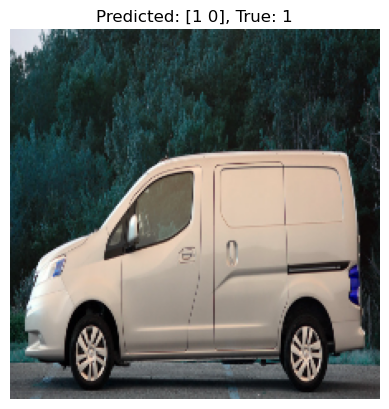

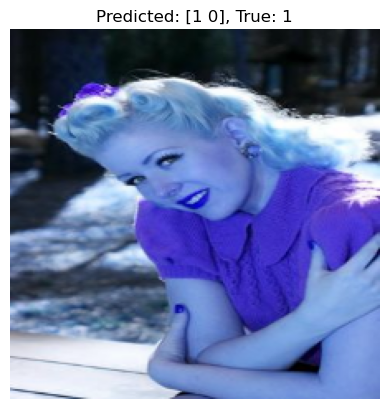

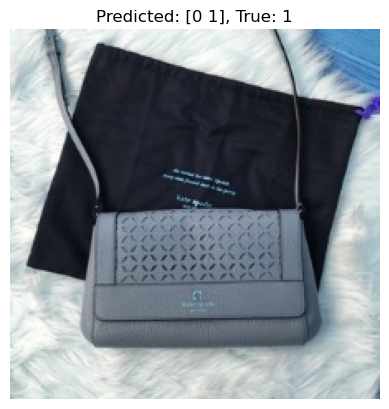

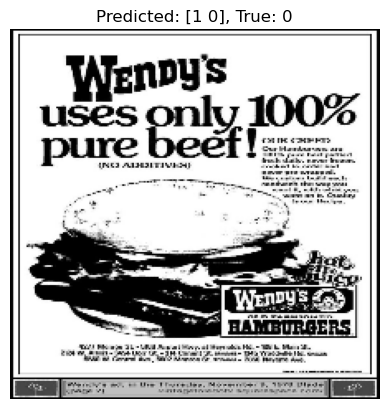

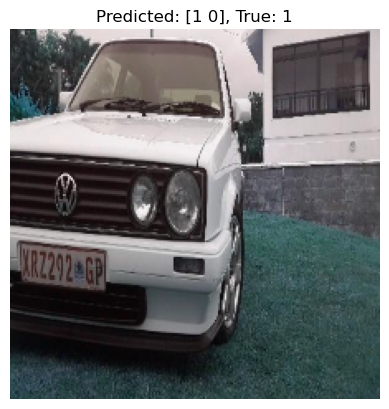

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


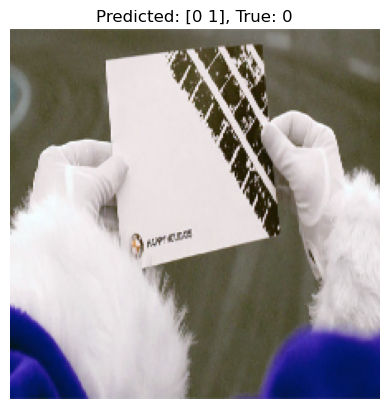

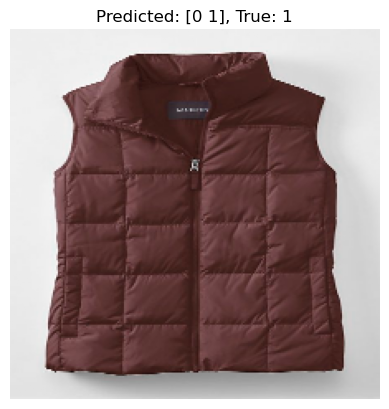

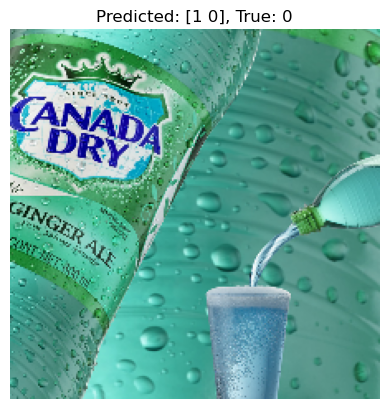

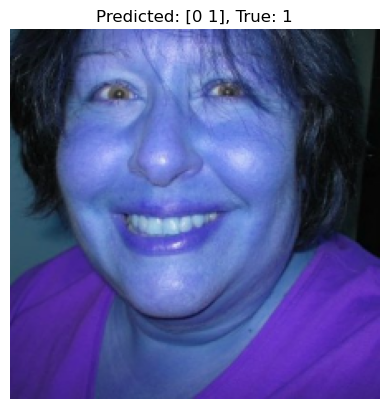

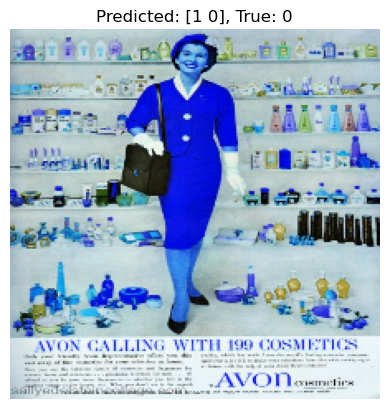

Do you want to continue checking? (yes/no): yes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


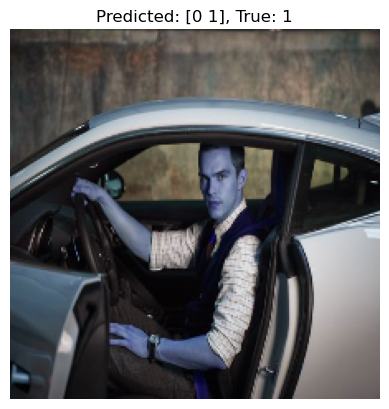

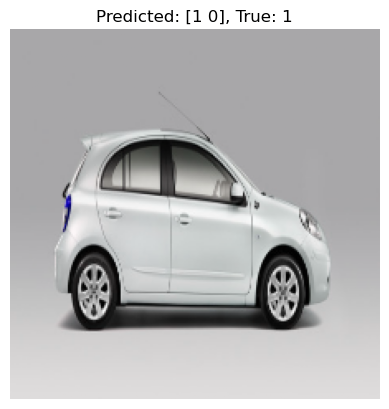

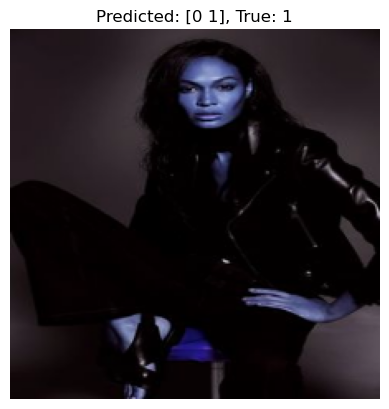

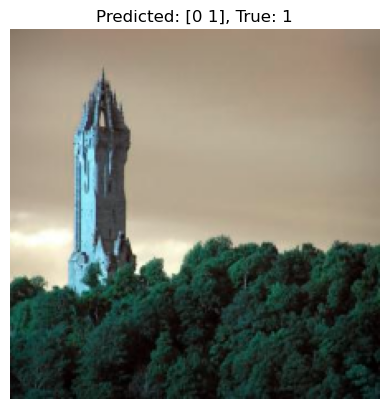

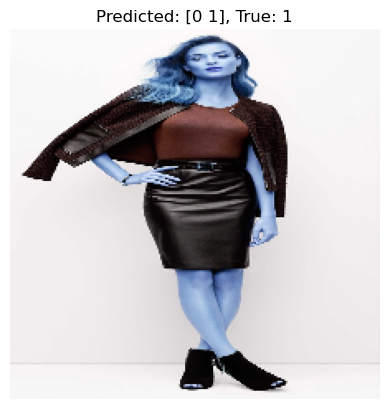

Do you want to continue checking? (yes/no): no


In [20]:
#Manually checking using few examples
import matplotlib.pyplot as plt
sample_indices = np.random.choice(X_test.shape[0], size=5, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]
predictions = model.predict(sample_images)
predicted_labels = np.round(predictions).astype(int)
for i in range(len(sample_indices)):
    plt.imshow(sample_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}, True: {sample_labels[i]}")
    plt.axis('off')
    plt.show()
def map_labels_to_strings(labels):
    label_map = {0: "ad", 1: "non-ad"}
    return [label_map[label] for label in labels]
def display_sample_images(images, labels, predictions):
    for i in range(len(images)):
        plt.imshow(images[i])
        plt.title(f"Predicted: {predictions[i]}, True: {labels[i]}")
        plt.axis('off')
        plt.show()
num_samples = 5
while True:
    sample_indices = np.random.choice(X_test.shape[0], size=num_samples, replace=False)
    sample_images = X_test[sample_indices]
    sample_labels = y_test[sample_indices]

    predictions = model.predict(sample_images)
    predicted_labels = np.round(predictions).astype(int)

    display_sample_images(sample_images, sample_labels, predicted_labels)

    user_input = input("Do you want to continue checking? (yes/no): ").lower()
    if user_input != 'yes':
        break

In [21]:
#Add probability scores and work for the web app
print("till now good")

till now good


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define a function to display sample images with predictions and probability scores
def display_sample_images_with_prob(images, labels, predictions, prob_scores):
    for i in range(len(images)):
        plt.imshow(images[i])
        plt.title(f"Predicted: {predictions[i]}, Probability: {prob_scores[i][0]:.2f}, True: {labels[i]}")
        plt.axis('off')
        plt.show()

y_pred_prob = model.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Display sample images with predictions and probability scores
display_sample_images_with_prob(X_test, y_test, y_pred, y_pred_prob)

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets